In [3]:
import dpnp as np
import pandas as pd
from sklearnex import sklearn_is_patched
sklearn_is_patched()
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
data=pd.read_csv('late.csv',encoding='latin')
print(data.head(2))

   No.          Time                    Source  \
0    1  0.000000e+00  2404:6800:4007:80a::200a   
1    2  2.240000e-07  2404:6800:4007:80a::200a   

                               Destination Protocol  Length  \
0  2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236      UDP     195   
1  2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236      UDP     112   

                    Info  
0  443  >  54762 Len=133  
1   443  >  54762 Len=50  


In [4]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117084 entries, 0 to 117083
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   No.          117084 non-null  int64  
 1   Time         117084 non-null  float64
 2   Source       117084 non-null  object 
 3   Destination  117084 non-null  object 
 4   Protocol     117084 non-null  object 
 5   Length       117084 non-null  int64  
 6   Info         117084 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.3+ MB
None


In [5]:
print(data.head(5))

   No.          Time                                   Source  \
0    1  0.000000e+00                 2404:6800:4007:80a::200a   
1    2  2.240000e-07                 2404:6800:4007:80a::200a   
2    3  2.737900e-04  2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236   
3    4  3.563550e-04  2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236   
4    5  5.886481e-02                 2404:6800:4007:80a::200a   

                               Destination Protocol  Length  \
0  2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236      UDP     195   
1  2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236      UDP     112   
2                 2404:6800:4007:80a::200a      UDP     107   
3                 2404:6800:4007:80a::200a      UDP     102   
4  2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236      UDP      87   

                    Info  
0  443  >  54762 Len=133  
1   443  >  54762 Len=50  
2   54762  >  443 Len=45  
3   54762  >  443 Len=40  
4   443  >  54762 Len=25  


In [6]:
data.describe()

,No.,Time,Length
count,117084.000000,117084.000000,117084.000000
mean,58542.500000,2557.265139,675.000145
std,33799.383796,1998.481859,1062.354699
min,1.000000,0.000000,42.000000
25%,29271.750000,745.480519,86.000000
50%,58542.500000,2051.053935,101.000000
75%,87813.250000,3985.455522,1292.000000
max,117084.000000,6941.356968,17838.000000


In [7]:
frequency=data['Source'].value_counts()


<class 'pandas.core.series.Series'>
Index: 31 entries, 2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236 to 2404:6800:4002:809::2002
Series name: count
Non-Null Count  Dtype
--------------  -----
31 non-null     int64
dtypes: int64(1)
memory usage: 496.0+ bytes
None


Text(0, 0.5, 'frequency')

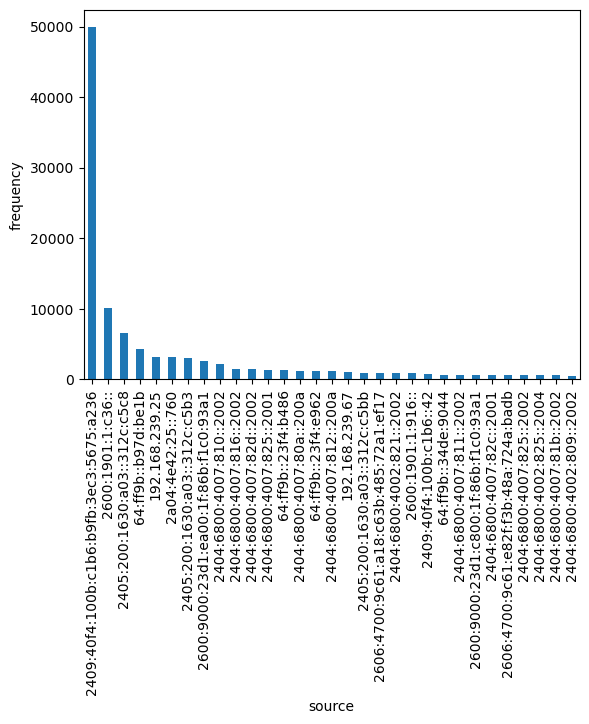

In [8]:
import matplotlib.pyplot as plt
for i in frequency.index:
    if frequency[i]<500:
        frequency=frequency.drop(i)
print(frequency.info())
frequency.plot(kind='bar')
plt.xlabel('source')
plt.ylabel('frequency')

In [9]:
destinationfrequency=data['Destination'].value_counts()
print(destinationfrequency.head(2))


Destination
2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236    60423
2600:1901:1:c36::                           8550
Name: count, dtype: int64


Text(0, 0.5, 'Frequency')

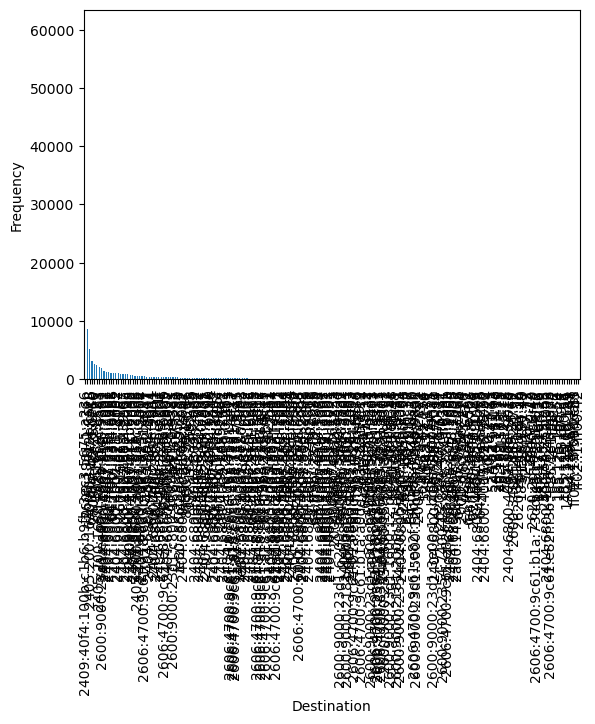

In [10]:
for i in destinationfrequency.index:
    if destinationfrequency[i]<5000:
        destinaionfrequency=destinationfrequency.drop(i)
destinationfrequency.plot(kind='bar')
plt.xlabel('Destination')
plt.ylabel('Frequency')


Text(0, 0.5, 'frequency')

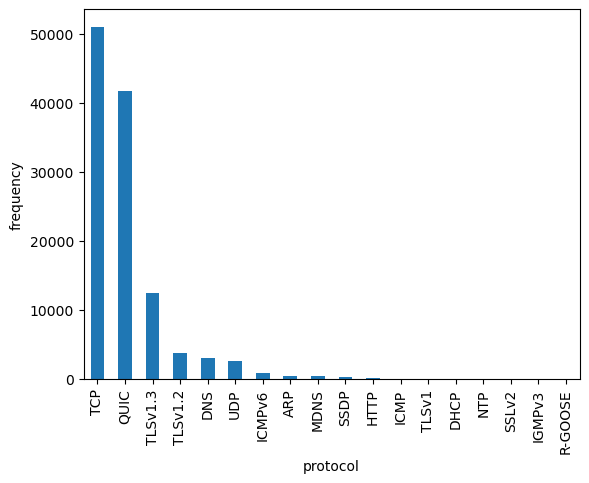

In [11]:
protocoltraffic=data['Protocol'].value_counts()
protocoltraffic.plot(kind='bar')
plt.xlabel('protocol')
plt.ylabel('frequency')


In [30]:

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd
import tensorflow as tf
TF_ENABLE_ONEDNN_OPTS=1

features = ['Protocol', 'Length']
X = data[features]
X_encoded = pd.get_dummies(X, columns=['Protocol'])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

input_dim = X_scaled.shape[1]
encoding_dim = 10

# Build and train the improved autoencoder model
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
    tf.keras.layers.Dense(32, activation='relu'),  # Add another hidden layer
    tf.keras.layers.Dense(encoding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Add a hidden layer for decoding
    tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),  # Add another hidden layer
    tf.keras.layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32)  # Increase the number of epochs

# Use the trained model for anomaly detection
reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 99.9)  # Adjust the percentile threshold based on your data

# Identify congestion points based on the anomaly scores
anomalypoints = data[mse > threshold]
print("Anomaly points:")
print(anomalypoints)







Epoch 1/20
3659/3659 [==============================] - 13s 3ms/step - loss: 0.0052
Epoch 2/20
3659/3659 [==============================] - 20s 6ms/step - loss: 0.0011
Epoch 3/20
3659/3659 [==============================] - 17s 5ms/step - loss: 0.0011
Epoch 4/20
3659/3659 [==============================] - 18s 5ms/step - loss: 0.0010
Epoch 5/20
3659/3659 [==============================] - 16s 4ms/step - loss: 0.0010
Epoch 6/20
3659/3659 [==============================] - 17s 5ms/step - loss: 0.0010
Epoch 7/20
3659/3659 [==============================] - 16s 4ms/step - loss: 0.0010
Epoch 8/20
3659/3659 [==============================] - 16s 4ms/step - loss: 0.0010
Epoch 9/20
3659/3659 [==============================] - 21s 6ms/step - loss: 0.0010
Epoch 10/20
3659/3659 [==============================] - 16s 4ms/step - loss: 0.0010
Epoch 11/20
3659/3659 [==============================] - 18s 5ms/step - loss: 0.0010
Epoch 12/20
3659/3659 [==============================] - 18s 5ms/step - lo

In [28]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier
features = data[['Protocol','Length']]
isolation_forest = IsolationForest(contamination=0.0045, random_state=42)  # Adjust the contamination parameter
anomaly_scores_if = isolation_forest.fit_predict(features)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed
labels_rf = np.where(anomaly_scores_if == 1, 1, 0)
random_forest.fit(features, labels_rf)
anomaly_predictions_rf = random_forest.predict(features)
anomalies = data[anomaly_predictions_rf == 0]
print("Anomalies:")
print(anomalies)


/home/nb/miniconda3/envs/idp/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Anomalies:
           No.         Time                                Source  \
4147      4148   162.967202  2600:9000:23d1:ea00:1f:86b:f1c0:93a1   
4292      4293   163.058966  2600:9000:23d1:ea00:1f:86b:f1c0:93a1   
4295      4296   163.058985  2600:9000:23d1:ea00:1f:86b:f1c0:93a1   
4353      4354   163.108182  2600:9000:23d1:ea00:1f:86b:f1c0:93a1   
4356      4357   163.108201  2600:9000:23d1:ea00:1f:86b:f1c0:93a1   
...        ...          ...                                   ...   
89900    89901  4202.710946                      64:ff9b::d43:905   
92911    92912  4503.367935                      64:ff9b::d43:905   
105479  105480  5705.920885                      64:ff9b::d43:905   
105480  105481  5705.920886                      64:ff9b::d43:905   
111316  111317  6307.050279                      64:ff9b::d43:905   

                                    Destination  Protocol  Length  \
4147    2409:40f4:100b:c1b6:b9fb:3ec3:5675:a236        16    7334   
4292    2409:40f4:100b